## Homework_2023_05_15 时间序列 & 神经网络基础   
教师：胡俊峰

助教：谷东润 陈福康

本次作业总分为13分，达到10分即为满分，另外3分是附加分

注意：为提高大家的知识理解与应用能力，时间序列部分需要你自行发挥的内容较多，这些部分在评分时将不会有硬性的步骤要求，而是根据你完成的质量和分析的质量来综合给分（事实上，整体理解与综合分析能力在时间序列问题中是尤为重要的），不必过于纠结某一具体细节是否在评分标准内，加油！


## 第零部分：请认真阅读代码，理解代码的功能

卡尔曼滤波

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
font = {'family': 'SimSun',
        'size': '10.5' 
        }
plt.rc('font', **font)
plt.rc('axes', unicode_minus=False)
 
 
class Kf_Params:
    B = 0  # 外部输入为0
    u = 0  # 外部输入为0
    K = float('nan')  # 卡尔曼增益无需初始化
    z = float('nan')  # 这里无需初始化，每次使用kf_update之前需要输入观察值z
    P = np.diag(np.ones(4))  # 初始P设为0 
 
    # 初始状态：函数外部提供初始化的状态，本例使用观察值进行初始化，vx，vy初始为0
    x = []
    G = []
 
    # 状态转移矩阵A
    # 和线性系统的预测机制有关，这里的线性系统是上一刻的位置加上速度等于当前时刻的位置，而速度本身保持不变
    A = np.eye(4) + np.diag(np.ones((1, 2))[0, :], 2)
 
    # 预测噪声协方差矩阵Q：假设预测过程上叠加一个高斯噪声，协方差矩阵为Q
    # 大小取决于对预测过程的信任程度。比如，假设认为运动目标在y轴上的速度可能不匀速，那么可以把这个对角矩阵
    # 的最后一个值调大。有时希望出来的轨迹更平滑，可以把这个调更小
    Q = np.diag(np.ones(4)) * 0.1
 
    # 观测矩阵H：z = H * x
    # 这里的状态是（坐标x， 坐标y， 速度x， 速度y），观察值是（坐标x， 坐标y），所以H = eye(2, 4)
    H = np.eye(2, 4)
 
    # 观测噪声协方差矩阵R：假设观测过程上存在一个高斯噪声，协方差矩阵为R
    # 大小取决于对观察过程的信任程度。比如，假设观测结果中的坐标x值常常很准确，那么矩阵R的第一个值应该比较小
    R = np.diag(np.ones(2)) * 0.1
 
 
def kf_init(px, py, vx, vy):
    # 本例中，状态x为（坐标x， 坐标y， 速度x， 速度y），观测值z为（坐标x， 坐标y）
    kf_params = Kf_Params()
    kf_params.B = 0
    kf_params.u = 0
    kf_params.K = float('nan')
    kf_params.z = float('nan')
    kf_params.P = np.diag(np.ones(4))
    kf_params.x = [px, py, vx, vy]
    kf_params.G = [px, py, vx, vy]
    kf_params.A = np.eye(4) + np.diag(np.ones((1, 2))[0, :], 2)
    kf_params.Q = np.diag(np.ones(4)) * 0.1
    kf_params.H = np.eye(2, 4)
    kf_params.R = np.diag(np.ones(2)) * 0.1
    return kf_params
 
 
def kf_update(kf_params):
    # 以下为卡尔曼滤波的五个方程（步骤）
    a1 = np.dot(kf_params.A, kf_params.x)
    a2 = kf_params.B * kf_params.u
    x_ = np.array(a1) + np.array(a2)
 
    b1 = np.dot(kf_params.A, kf_params.P)
    b2 = np.dot(b1, np.transpose(kf_params.A))
    p_ = np.array(b2) + np.array(kf_params.Q)
 
    c1 = np.dot(p_, np.transpose(kf_params.H))
    c2 = np.dot(kf_params.H, p_)
    c3 = np.dot(c2, np.transpose(kf_params.H))
    c4 = np.array(c3) + np.array(kf_params.R)
    c5 = np.linalg.matrix_power(c4, -1)
    kf_params.K = np.dot(c1, c5)
 
    d1 = np.dot(kf_params.H, x_)
    d2 = np.array(kf_params.z) - np.array(d1)
    d3 = np.dot(kf_params.K, d2)
    kf_params.x = np.array(x_) + np.array(d3)
 
    e1 = np.dot(kf_params.K, kf_params.H)
    e2 = np.dot(e1, p_)
    kf_params.P = np.array(p_) - np.array(e2)
 
    kf_params.G = x_
    return kf_params
 
 
def accuracy(predictions, labels):
    return np.array(predictions) - np.array(labels)
 


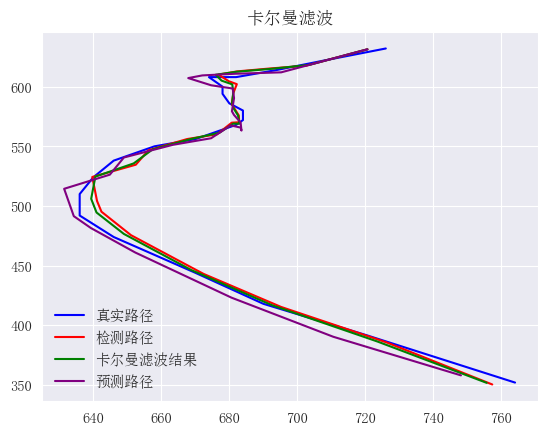

[[-5.4        -0.7       ]
 [-4.58181818 -3.77727273]
 [-1.86696035  0.88942731]
 [ 0.20809969  4.51825545]
 [ 2.00056586  1.98601069]
 [ 1.70377857  1.05589697]
 [ 2.85716089  1.93268741]
 [ 3.16304702  1.44725796]
 [ 0.82221324  0.45770473]
 [-2.79698331  2.02862495]
 [-1.45543694  1.89218001]
 [-1.02643566 -2.58195893]
 [ 1.01894224  0.95448879]
 [ 1.16876094  3.06887511]
 [ 1.10734916 -0.57406179]
 [-1.14701401  0.2172807 ]
 [-0.51547091 -2.48551873]
 [ 5.87618882 -2.3240735 ]
 [ 0.62070854  0.64769776]
 [ 3.37747443 -3.98289077]
 [ 4.95143595  2.53441544]
 [ 2.99332009  2.57928957]
 [-1.17946821  2.29714653]
 [ 2.60174957 -1.21233093]
 [ 3.49455815 -5.54628404]
 [-8.34041064 -0.23971885]]


In [56]:
path = '9.xlsx'
data_A = pd.read_excel(path, header=None)
data_A_x = list(data_A.iloc[::, 0])
data_A_y = list(data_A.iloc[::, 1])
A = np.array(list(zip(data_A_x, data_A_y)))

plt.figure()
plt.plot(data_A_x, data_A_y, 'blue')

# 检测到的路径
path = '10.xlsx'
data_B = pd.read_excel(path, header=None)
data_B_x = list(data_B.iloc[::, 0])
data_B_y = list(data_B.iloc[::, 1])
B = np.array(list(zip(data_B_x, data_B_y)))

plt.plot(data_B_x, data_B_y, 'red')

# 卡尔曼滤波
kf_params_record = np.zeros((len(data_B), 4))
kf_params_p = np.zeros((len(data_B), 4))
t = len(data_B)
kalman_filter_params = kf_init(data_B_x[0], data_B_y[0], 0, 0)
for i in range(t):
    if i == 0:
        kalman_filter_params = kf_init(data_B_x[i], data_B_y[i], 0, 0)  # 初始化
    else:            
        kalman_filter_params.z = np.transpose([data_B_x[i], data_B_y[i]])  # 设置当前时刻的观测位置
        kalman_filter_params = kf_update(kalman_filter_params)  # 卡尔曼滤波
    kf_params_record[i, ::] = np.transpose(kalman_filter_params.x)
    kf_params_p[i, ::] = np.transpose(kalman_filter_params.G)

kf_trace = kf_params_record[::, :2]
kf_trace_1 = kf_params_p[::, :2]

plt.plot(kf_trace[::, 0], kf_trace[::, 1], 'green')
plt.plot(kf_trace_1[1:26, 0], kf_trace_1[1:26, 1], 'purple')
legend = ['真实路径', '检测路径', '卡尔曼滤波结果', '预测路径']
plt.legend(legend, loc="best", frameon=False)
plt.title('卡尔曼滤波')
plt.show()

p = accuracy(kf_trace, A)
print(p)

## 第一部分：时间序列（8分）

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

df = pd.read_csv('Stock_Price.csv')
df.head()


,Date,TWTR,KO,GM
0,2013-11-07,44.900002,30.350573,27.762348
1,2013-11-08,41.650002,30.518206,28.334280
2,2013-11-11,42.900002,30.381044,28.349743
3,2013-11-12,41.900002,30.388666,28.334280
4,2013-11-13,42.599998,30.571535,29.710032


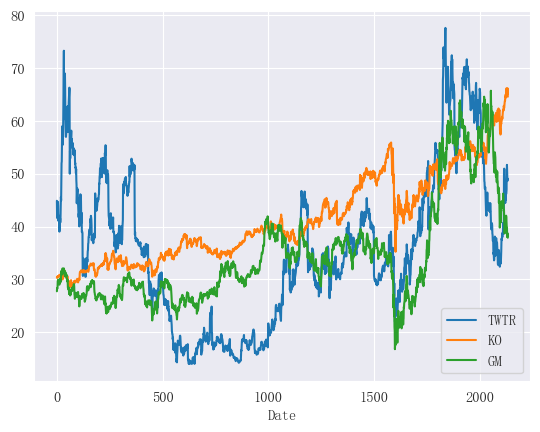

In [58]:
df[['TWTR', 'KO', 'GM']].plot()
plt.xlabel('Date')
plt.show()

1.1 请你结合课上老师讲授的知识、上次作业以及其它查阅得到的知识，对这三支股票的股价时间序列的基本性质与特征（平稳性、周期性等）进行分析，并可以尝试分析三支股票是否有（或在某些局部的时间段有）关联（2分）

In [59]:
# 平稳性检验
adf, pvalues, nobs, other = list(adfuller(df['TWTR']))[0:4]
print(f"TWTR: {adf}, {pvalues}, {nobs}, {other}")
adf, pvalues, nobs, other = list(adfuller(df['KO']))[0:4]
print(f"KO: {adf}, {pvalues}, {nobs}, {other}")
adf, pvalues, nobs, other = list(adfuller(df['GM']))[0:4]
print(f"GM: {adf}, {pvalues}, {nobs}, {other}")


TWTR: -2.1072659674823493, 0.24160297489559357, 15, 2118
KO: 0.04024578111864317, 0.9617365050440163, 12, 2121
GM: -1.7468451155639892, 0.407152272677313, 19, 2114


由上知，三支股票的股价时间序列都不平稳，最不平稳到最平稳排序：KO，GM，TWTR。

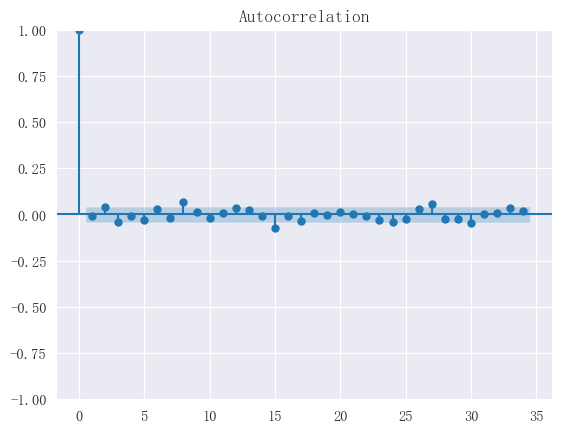

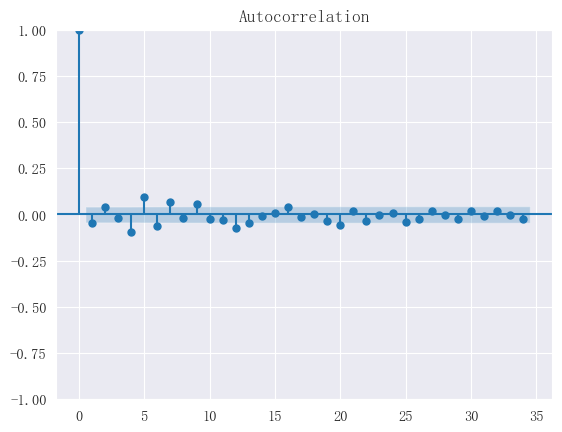

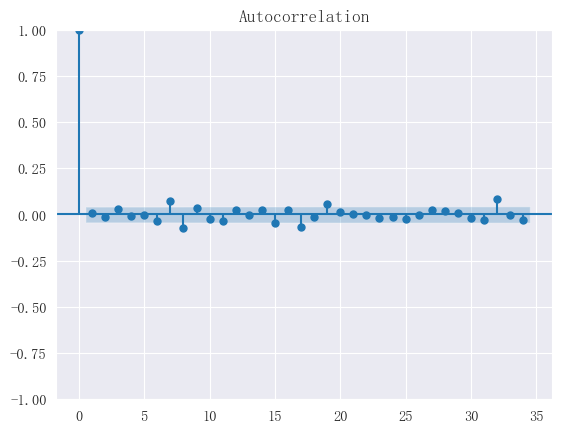

In [60]:
# 周期性检验
# 计算自相关系数
plot_acf(np.diff(df['TWTR']))
plot_acf(np.diff(df['KO']))
plot_acf(np.diff(df['GM']))
plt.show()

由上知，三支股票的股价时间序列差分后都有一定周期性，周期性主要表现在5天、7天、27天、32天等处。

相关性大于0.8的序号
[1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826]
[463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824,

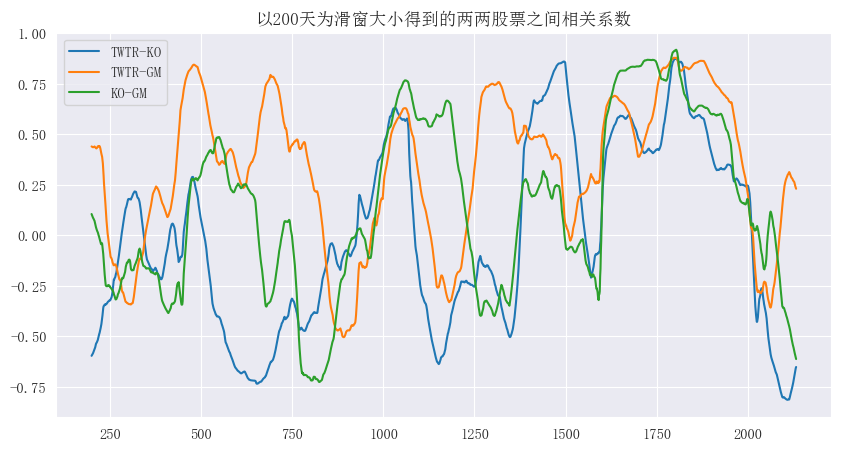

In [61]:
# 滑窗检验股票关联性
# 以200天为滑窗，计算滑窗内的相关系数
T_K = df['TWTR'].rolling(200).corr(df['KO'])
T_G = df['TWTR'].rolling(200).corr(df['GM'])
K_G = df['KO'].rolling(200).corr(df['GM'])
# 输出相关性大于0.8的时间段
print('相关性大于0.8的序号')
print(T_K[T_K > 0.8].index.tolist())
print(T_G[T_G > 0.8].index.tolist())
print(K_G[K_G > 0.8].index.tolist())
plt.figure(figsize=(10, 5))
plt.plot(T_K)
plt.plot(T_G)
plt.plot(K_G)
plt.title('以200天为滑窗大小得到的两两股票之间相关系数')
plt.legend(['TWTR-KO', 'TWTR-GM', 'KO-GM'])
plt.show()


可以看出，在局部时间段内，三支股票两两之间的相关性较高，但是在其他时间段内，相关性较低。
高于0.8的时间段分别是
第1467-1503天，1790-1826天
第464-493天，第1762-1895天
第1645-1813天

1.2 请你自行发挥，根据你对于时间序列的理解并结合上网查阅资料，给出一些股票时间序列能反映趋势或可以用来预测涨跌的指标（你也可以尝试进行自定义指标），给出指标的定义以及计算指标的代码，并借助该股票数据分析效果（4分）

（没有思路的同学可以尝试计算分析股票的KDJ指标和双均线指标，分析合理即可）

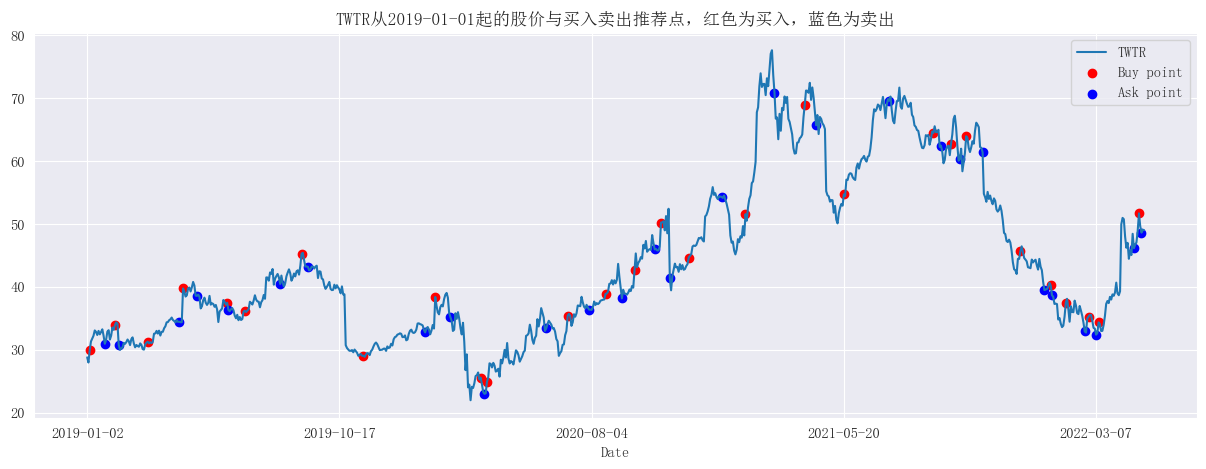

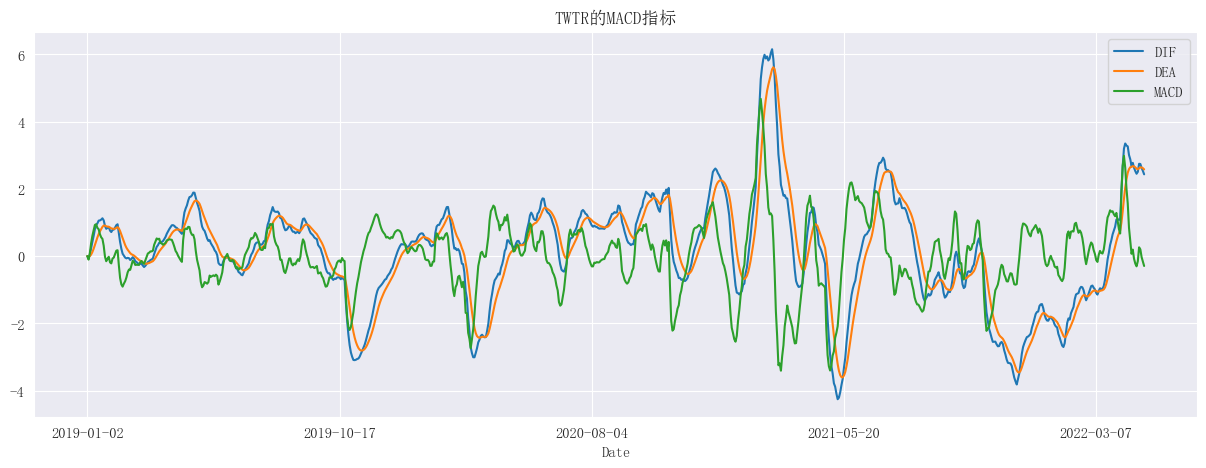

In [62]:
# MACD指标
def MACD(df, short=12, long=26, M=9):
    a = df['Close'].ewm(adjust=False, alpha=2 / (short + 1), ignore_na=True).mean()
    b = df['Close'].ewm(adjust=False, alpha=2 / (long + 1), ignore_na=True).mean()
    df['DIF'] = a - b
    df['DEA'] = df['DIF'].ewm(adjust=False, alpha=2 / (M + 1), ignore_na=True).mean()
    df['MACD'] = 2 * (df['DIF'] - df['DEA'])
    df['macd_g'], df['macd_d'] = None, None
    macd_position = df['DIF'] > df['DEA']
    pos1 = macd_position[(macd_position == True) & (macd_position.shift() == False)].index
    pos2 = macd_position[(macd_position == False) & (macd_position.shift() == True)].index
    df.loc[pos1, 'macd_g'] = df[['Date', 'Close']].loc[pos1,'Close']
    df.loc[pos2, 'macd_d'] = df[['Date', 'Close']].loc[pos2,'Close']
    return df

def stock_macd_ana(name:str, start_date:str):
    stock_data= df[['Date', 'TWTR']]
    stock_data = stock_data[stock_data['Date'] >= start_date]
    stock_data.plot(x='Date', y='TWTR',figsize=(15, 5))
    stock_data.rename(columns={'TWTR': 'Close'}, inplace=True)
    stock_data = MACD(stock_data)
    plt.scatter(stock_data['Date'],stock_data['macd_g'], c='r', marker='o')
    plt.scatter(stock_data['Date'],stock_data['macd_d'], c='b', marker='o')
    plt.legend(['TWTR', 'Buy point', 'Ask point'])
    plt.title(name+f'从{start_date}起的股价与买入卖出推荐点，红色为买入，蓝色为卖出')
    plt.show()
    stock_data.plot(x='Date', y=['DIF', 'DEA', 'MACD'],figsize=(15, 5))
    plt.title(name+'的MACD指标')
    plt.show()

# 以TWTR为例，从2019年1月1日开始
stock_macd_ana('TWTR', '2019-01-01')

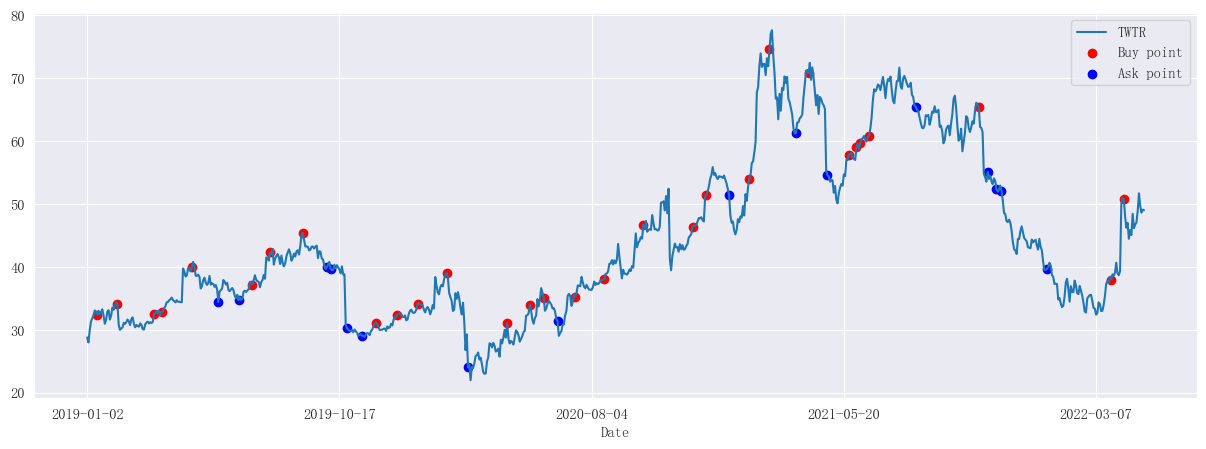

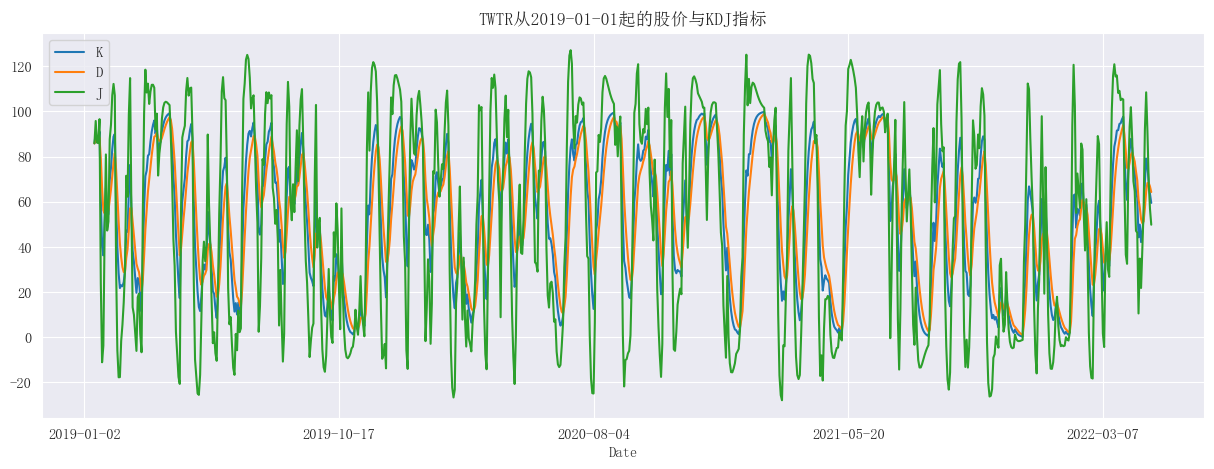

In [63]:
# KDJ指标
def KDJ(df, N=9, M1=3, M2=3, Buy_arg=80, Sell_arg=20):
    df['RSV'] = (df['Close'] - df['Close'].rolling(N).min()) / (df['Close'].rolling(N).max() - df['Close'].rolling(N).min()) * 100
    df['K'] = df['RSV'].ewm(adjust=False, alpha=1 / M1, ignore_na=True).mean()
    df['D'] = df['K'].ewm(adjust=False, alpha=1 / M2, ignore_na=True).mean()
    df['J'] = 3 * df['K'] - 2 * df['D']
    df['A'], df['B'] = None, None
    K_B = (df['K'] > Buy_arg) & (df['D'] > Buy_arg) & (df['J'] > Buy_arg)
    K_A = (df['K'] < Sell_arg) & (df['D'] < Sell_arg) & (df['J'] < Sell_arg)
    pos1 = K_B[(K_B == True) & (K_B.shift() == False)].index
    pos2 = K_A[(K_A == True) & (K_A.shift() == False)].index
    df.loc[pos1, 'B'] = df[['Date', 'Close']].loc[pos1,'Close']
    df.loc[pos2, 'A'] = df[['Date', 'Close']].loc[pos2,'Close']
    return df

def stock_kdj_ana(name:str, start_date:str):
    stock_data= df[['Date', 'TWTR']]
    stock_data = stock_data[stock_data['Date'] >= start_date]
    stock_data.plot(x='Date', y='TWTR',figsize=(15, 5))
    stock_data.rename(columns={'TWTR': 'Close'}, inplace=True)
    stock_data = KDJ(stock_data)
    plt.scatter(stock_data['Date'],stock_data['B'], c='r', marker='o')
    plt.scatter(stock_data['Date'],stock_data['A'], c='b', marker='o')
    plt.legend(['TWTR', 'Buy point', 'Ask point'])
    stock_data.plot(x='Date', y=['K', 'D', 'J'],figsize=(15, 5))
    plt.legend(['K', 'D', 'J'])
    plt.title(name+f'从{start_date}起的股价与KDJ指标')
    plt.show()

# 以TWTR为例，从2019年1月1日开始
stock_kdj_ana('TWTR', '2019-01-01')

1.3 噪声处理（2分）

example.wav中录制了一段鸟鸣声，但背景中存在很大的噪声，希望能编写一段程序去除噪声。这里采用的是librosa库，有关内容可参考其官方文档https://librosa.org/doc/latest/tutorial.html
<br>（1）绘制音频文件example.wav的图像。
<br>（2）去除音频文件中的噪声。（可使用scipy.signal.lfilter）https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html
<br>（3）绘制去除噪声后的音频文件图像。

In [64]:
import librosa
import librosa.display
from scipy import signal
from IPython.display import Audio,display

sr = 16000
e_file='example.wav'
y,sr = librosa.load(e_file, mono=True, sr=sr, offset=0, duration=10)

display(Audio(y,rate=sr))

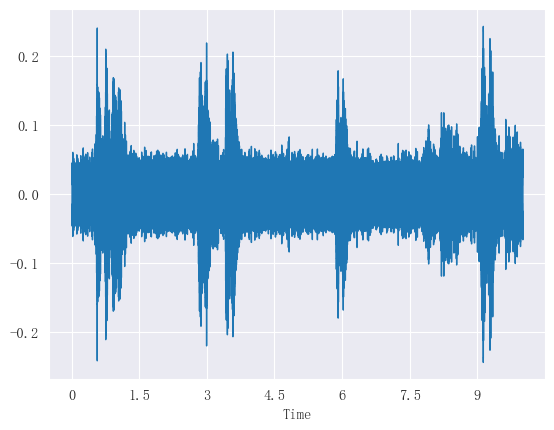

In [65]:
librosa.display.waveshow(y,sr=sr)

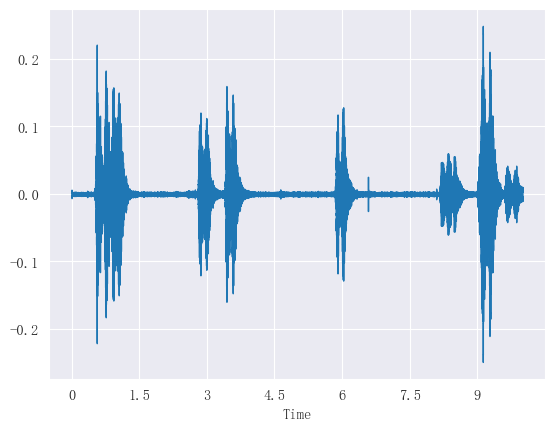

In [66]:

# 去除音频文件中的噪声
cutoff_freq_low = 3500  # 设置带通滤波器的低频截止频率
cutoff_freq_high = 7999  # 设置带通滤波器的高频截止频率

# 设计带通滤波器
nyquist_freq = 0.5 * sr
normal_cutoff_low = cutoff_freq_low / nyquist_freq
normal_cutoff_high = cutoff_freq_high / nyquist_freq
b, a = signal.butter(4, [normal_cutoff_low, normal_cutoff_high], btype='band')

# 应用滤波器
y_filtered = signal.lfilter(b, a, y)
librosa.display.waveshow(y_filtered,sr=sr)
display(Audio(y_filtered,rate=sr))

## 第二部分：神经网络基础(5分)

2.1补全下列常用的激活函数及其导数,熟记并画出它们的图像（2分），你也可以查阅资料后补充一些其它常用的激活函数（不计分）

In [67]:
import numpy as np
import matplotlib.pyplot as plt
def sigmoid(x):
    #todo
    return 1.0/(1.0 + np.exp(-x))

def d_sigmoid(x):
    #todo
    return sigmoid(x)*(1-sigmoid(x))

def ReLU(x):
    #todo
    return np.where(x>0,x,0)

def d_ReLU(x):
    #todo
    return np.where(x>0,1,0)

def Tanh(x):
    #todo
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def d_Tanh(x):
    #todo
    return 1-Tanh(x)**2

def Leaky_ReLU(x):
    return np.where(x>0,x,0.01*x)

def d_Leaky_ReLU(x):
    return np.where(x>0,1,0.01)

def ELU(x):
    return np.where(x>0,x,0.01*(np.exp(x)-1))

def d_ELU(x):
    return np.where(x>0,1,0.01*np.exp(x))

def Softplus(x):
    return np.log(1+np.exp(x))

def d_Softplus(x):
    return 1/(1+np.exp(-x))

def Softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def d_Softmax(x):
    return Softmax(x)*(1-Softmax(x))

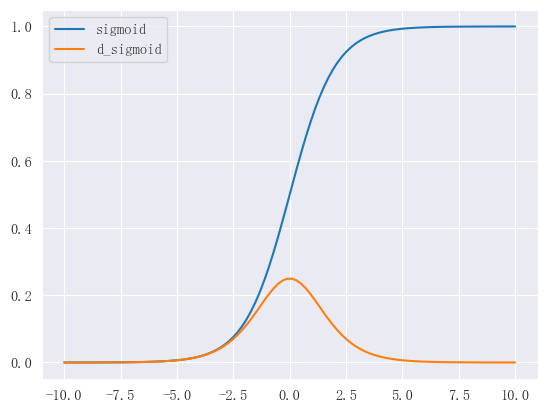

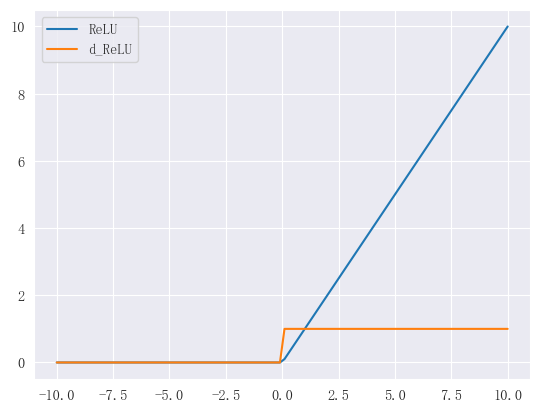

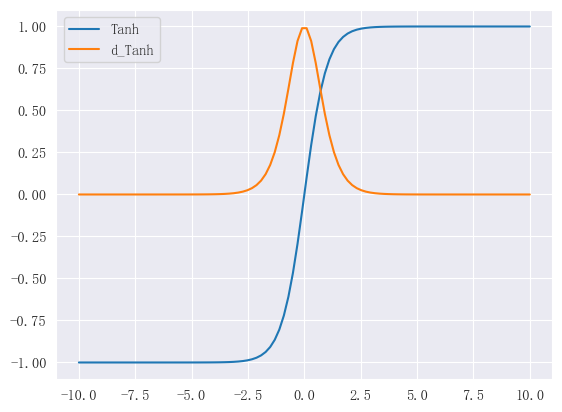

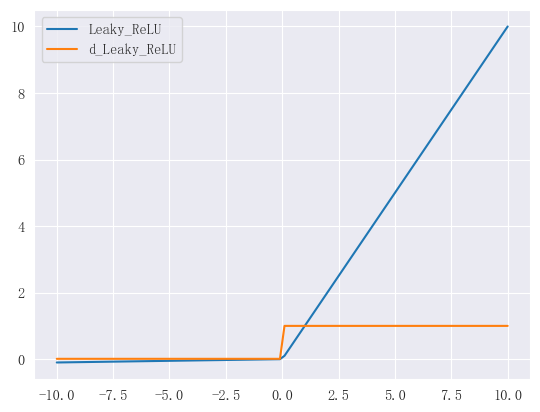

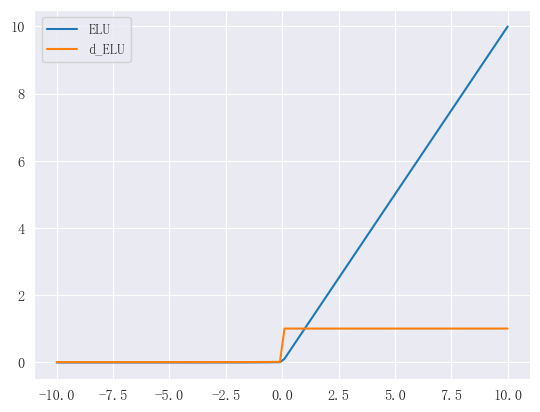

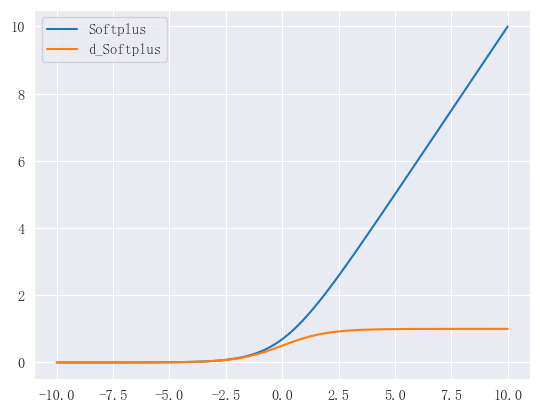

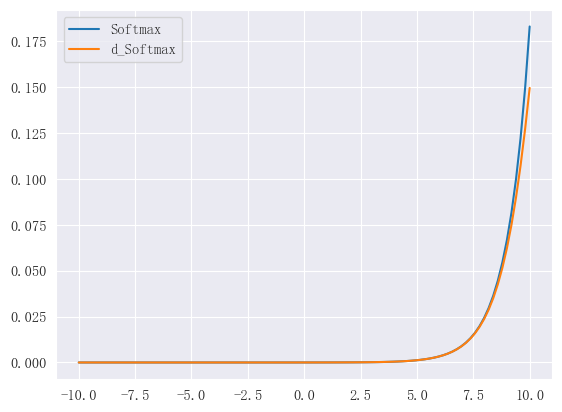

In [68]:
#画出上述常用激活函数与对应导数在区间[-10,10]的图像
x = np.linspace(-10,10,100)
def show(label):
    eval(f'plt.plot(x,{label}(x),label=\'{label}\')')
    eval(f'plt.plot(x,d_{label}(x),label=\'d_{label}\')')
    plt.legend()
    plt.show()
_ = [show(i) for i in ['sigmoid','ReLU','Tanh','Leaky_ReLU','ELU','Softplus','Softmax']]

2.2使用反向传播算法，用三次函数拟合sin(x)函数在$[-\pi,\pi]$区间的取值（3分）

In [109]:
import matplotlib.pyplot as plt
import numpy as np
 
import  numpy as np
import math
#在区间等距离散采样
x = np.linspace(-math.pi,math.pi,200)
y = np.sin(x)

In [114]:
#初始化a+b*x+c*x^2+d*x^3中的参数a,b,c,d
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

learning_rate = 1e-5    #可尝试对比不同的学习率，不计分

In [115]:
for t in range(6000):
    y_pred = a + b*x + c*x**2 + d*x**3
    
    #计算loss（0.5分）
    loss = np.sum((y_pred-y)**2)
 
    print(t, loss)
    
    #反向传播（1分）
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = np.sum(grad_y_pred)
    grad_b = grad_y_pred@x.T
    grad_c = grad_y_pred@(x**2).T
    grad_d = grad_y_pred@(x**3).T
 
    # 更新参数（1分）
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d
 
print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')


0 10949.50007017
1 8017.321903629763
2 6569.585609362993
3 5531.927672613294
4 4689.628349286386
5 3985.166082500751
6 3392.117146515154
7 2892.147815579015
8 2470.505202833663
9 2114.87649658064
10 1814.9027272067783
11 1561.853801042978
12 1348.369697774871
13 1168.2449772161197
14 1016.2475724244757
15 887.9660926855321
16 779.6810932373329
17 688.2565397116553
18 611.0482973811795
19 545.8269743854144
20 490.71286737389835
21 444.1211112328417
22 404.71543233459283
23 371.369155806652
24 343.1323289932052
25 319.20400175571575
26 298.90885473820344
27 281.6774935985791
28 267.02983418208385
29 254.56109380808408
30 243.92997988912938
31 234.8487312204171
32 227.07472133962779
33 220.4033789390769
34 214.6622187443565
35 209.70580867759446
36 205.4115264447044
37 201.67598172177313
38 198.41199953824352
39 195.54607683054664
40 193.01623794718057
41 190.77022652783342
42 188.7639809947052
43 186.96034917012682
44 185.3280045123965
45 183.84053234507158
46 182.4756594154456
47 181.21

画出得到的三次函数与sinx在$[-\pi,\pi]$区间内的图像(0.5分)

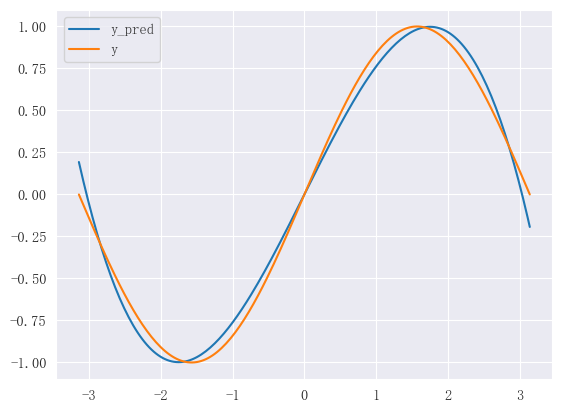

In [116]:
#todo
plt.plot(x,y_pred,label='y_pred')
plt.plot(x,y,label='y')
plt.legend()
plt.show()

Result: y = -0.0018721619362593322 + 0.9237304524491762 x + 0.0010206715877337244 x^2 + -0.13150479801360518 x^3 + -9.775742588683432e-05 x^4 + 0.00374025550234933 x^5


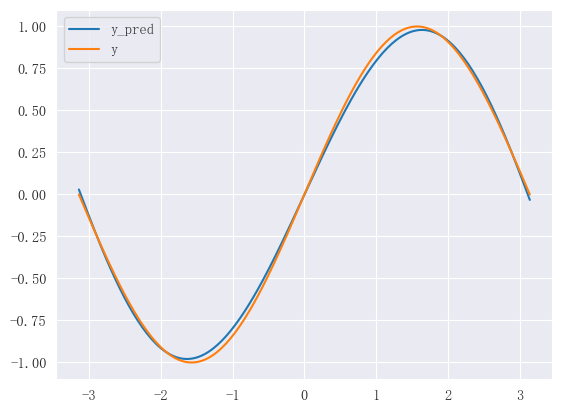

In [113]:
# 增加至5次方，拟合效果更好
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()
e = np.random.randn()
f = np.random.randn()
learning_rate = 1e-7
for t in range(500000):
    y_pred = a + b * x + c * x ** 2 + d * x ** 3 + e * x ** 4 + f * x ** 5
    loss = np.sum((y_pred - y) ** 2)
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = np.sum(grad_y_pred)
    grad_b = np.sum(grad_y_pred * x)
    grad_c = np.sum(grad_y_pred * x ** 2)
    grad_d = np.sum(grad_y_pred * x ** 3)
    grad_e = np.sum(grad_y_pred * x ** 4)
    grad_f = np.sum(grad_y_pred * x ** 5)
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d
    e -= learning_rate * grad_e
    f -= learning_rate * grad_f
print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3 + {e} x^4 + {f} x^5')
plt.plot(x, y_pred, label='y_pred')
plt.plot(x, y, label='y')
plt.legend()
plt.show()